In [7]:
import cupy as cp
import numpy as np
from numba import jit, prange, njit, vectorize
import pandas
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate as itp
import itertools as it
import warnings as w
import os 
import pylab
import math
import time
import scripts.tools as tools
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate as itp
import pandas as pd 
from scipy.optimize import curve_fit
from scipy.signal import argrelmax
import qcodes
import scripts.tvregdiff as tvregdiff


# Settings

In [ ]:
R=0.75 #cm
H=0.2
N=500
M=200
position_of_electrons=100 

hr=R/N
hz=H/M

e=4.80324e-10
mass=9.1e-28

N_Vib=cp.round(0.4/hr)
N_Vmb=cp.round(0.57/hr)
N_Vob = cp.round(0.7/hr)

N_Vit=N_Vib
N_Vmt=N_Vmb
N_Vot = N_Vob

x=np.linspace(0,R,N+1)
folder = "GreenFunction//"
eps=1e-10
GreenFuncName = 'Green_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(eps)) + '.npy'

G = cp.load(folder+GreenFuncName)

dGr = cp.zeros((N, N))
dGzTOP = cp.zeros((N, N))

for n in range(0, N):
    for i in range(0, N):
        # ----------- Green function difference along the charge pool ----------- #
        dGr[n,i] = -4 * cp.pi * e * (G[position_of_electrons,i+1,n] - G[position_of_electrons,i,n])
        # ----------- Green function difference across the cell's top ------------# 
        dGzTOP[n, i] = -4 * cp.pi * e * (G[M, i, n] - G[M-1, i, n])*(hr/hz)


# $V_{mb}$ sweep

## Load the density functions

<>:70: SyntaxWarning: invalid escape sequence '\e'
<>:70: SyntaxWarning: invalid escape sequence '\e'
C:\Users\riken\AppData\Local\Temp\ipykernel_59224\2759616878.py:70: SyntaxWarning: invalid escape sequence '\e'
  plt.title(f'Density profiles for different Vmb potentials ($\epsilon={eps} ,N={N}, M={M}$)')


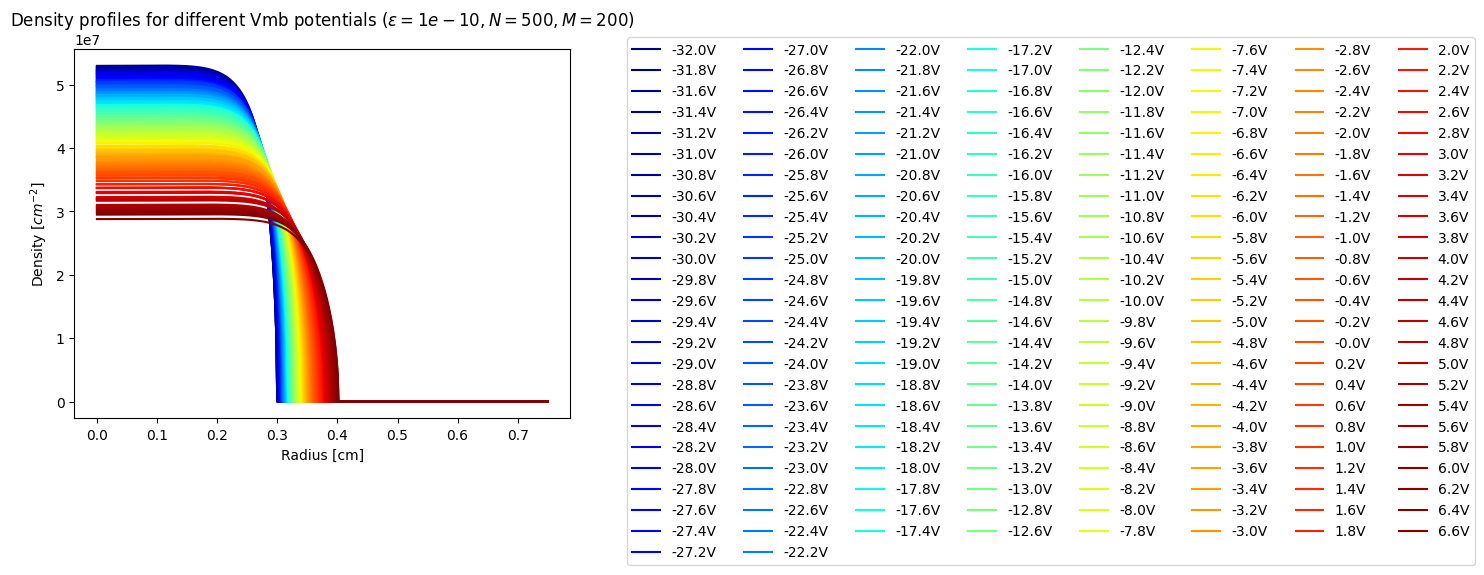

In [ ]:
# choose the same parameters as for density calculation 
# so that the loaded files do exist
# pay attention to the last voltage 
Vib=10
Vob=-32


startVmb = -32
endVmb = 6.8
stepVmb = 0.2
# Calculate the number of files (steps) to determine the colormap size
v_loop = np.arange(startVmb, endVmb, stepVmb)
numFiles = len(v_loop)
 
# Generate a colormap
colormap = plt.jet()

# Define the base path to the files
# if you downloaded the folder Vmbsweep from the drive: https://drive.google.com/drive/folders/1lC1xuzMQvBS7sev4N5r9cZi6F-KcE2N-
# and that you put it in one of your folders on your desktop, the folder path should look like this:
folder =f"C:/Users/username/Desktop/foldername/VmbSweep/Vib10V_Vobm32V/"

column_names = ["rcm", "densitycm2"]
column_types = {"rcm": "float64", "densitycm2": "float64"}


# creates a label for each plotted line
legLabels = [None] * int(numFiles)

# Create a list to store the data for each file
DataStruct = [{} for _ in range(numFiles)]

A = cp.zeros(N+1)
rdash = cp.zeros(N+1)

A[0] = cp.pi * cp.power(hr/2, 2)
A[N] = cp.pi * (N + 1 - 5/4) * cp.power(hr, 2)
A[1:N] = 2 * cp.pi * (cp.arange(2, N+1) - 1) * cp.power(hr, 2)

rdash[0:N+1] = (cp.arange(0, N+1) + 1/2) * hr

# Loop through each file
colors = plt.cm.jet(np.linspace(0,1,len(v_loop)))
fileIndex = 0 # Initialize a counter for the file index
for v in v_loop:
    # Generate the filename
    Vmb_str = f"{v:.1f}".replace(".", "p")

    if np.abs(v) < 0.01:
        Vmb_str = f"{-v:.1f}".replace(".", "p")

    filename = f"fixed_electron_number_density/FixedN_Vib{Vib}_Vob{Vob}_Vmb{Vmb_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    file = np.load(folder+filename, allow_pickle=True)
    
    DataStruct[fileIndex] = {
        'r': file[0],
        'density': file[1],
        'Vmb': v,
        'N_electrons': np.sum(cp.asnumpy(A)*file[1])
    }  

    # Plot density vs r with the color corresponding to the voltage
    plt.plot(DataStruct[fileIndex]['r'], DataStruct[fileIndex]['density'], color=colors[fileIndex])

    # Generate label for this line and store it
    legLabels[fileIndex] = f"{DataStruct[fileIndex]['Vmb']:.1f}V"
    fileIndex += 1 # Increment the file index


plt.xlabel('Radius [cm]')
plt.ylabel('Density $[cm^{-2}]$')
plt.title(f'Density profiles for different Vmb potentials ($\epsilon={eps} ,N={N}, M={M}$)')
plt.legend(legLabels, ncol=8, bbox_to_anchor=(1.1, 1.05))

plt.show()

# check if the density plots have the same profile as in the ones plotted in DensityProfile_Vmb_sweep.ipynb

## Define function to calculate $\tilde \Phi$ the potential created by the AC voltage

In [40]:
iRange = cp.arange(2, N+1)
# function to efficiently copy a 2D array
@njit(parallel=True, fastmath=True)
def copyAr2D(dst, src):
    for i in prange(src.shape[0]):
        for j in range(src.shape[1]):
            dst[i, j] = src[i, j]


fitilStart = cp.full((M+1,N+1),-1/300)
fitil = cp.full((M+1,N+1),-1/300)
aStart = cp.zeros((M-1, N+1))
a = cp.zeros((M-1, N+1))

# function to calculate the potential created by the AC voltage
def fitilSOLUT(R,H,N,M,Vib,Vmb,Vob,N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr):
    cp.copyto(fitil, fitilStart)


    # --------------- boundary conditions on the electrodes ----------------- #
    fitil[0, 0:int(N_Vib)] = Vib
    fitil[0, int(N_Vib):int(N_Vmb)] = Vmb
    fitil[0, int(N_Vmb):int(N_Vob)] = Vob
    fitil[0, int(N_Vob):] = Vr
        
    fitil[M, 0:int(N_Vit)] = Vit
    fitil[M, int(N_Vit):int(N_Vmt)] = Vmt
    fitil[M, int(N_Vmt):int(N_Vot)] = Vot
    fitil[M, int(N_Vot):] = Vr
    
      
    
    fitil[:, N] = Vr
    
    
    # ---------------- relaxation for homogenious solution ------------------ #
    max_err= 1
    
    
    count = 0
    errHere = 1e-10
    print(count)
    cp.copyto(a, aStart)
    while (max_err > errHere):

        count += 1
        if(count % 10000 == 0):
            print(max_err)

        cp.copyto(a, fitil[1:M, 0:N+1])
        fitil[1:M, 0] = (4 * (hz/hr) * fitil[1:M, 1] + (hr/hz) * fitil[0:M-1, 0] + (hr/hz) * fitil[2:M+1, 0])/(4 * hz/hr + 2 * hr/hz)

        fitil[1:M, 1:N] = ((iRange - 1/2 - 1) * (hz/hr) * fitil[1:M, 0:N-1] + (iRange + 1/2 - 1) * (hz/hr) * fitil[1:M, 2:N+1] + (iRange-1) * (hr/hz) * fitil[0:M-1, 1:N] + (iRange-1) * (hr/hz) * fitil[2:M+1, 1:N])/(2 * (iRange-1) * (hz/hr + hr/hz))
       
        max_err = np.amax(cp.abs(fitil[1:M, 0:N+1] - a))

    return fitil
    

## Calculate $\tilde \Phi$ created by the AC voltage

In [18]:
Vib_AC=0/300
Vmb_AC=0/300
Vob_AC=0/300
# only 1 V is applied to the top inner electrode
# all the other electrodes are set to 0 (they only participate in the DC potential)
Vit_AC = 1/300
Vmt_AC=0/300
Vot_AC=0/300

Vr=0

# calculate the potential created by the AC voltage
phitil = fitilSOLUT(R,H,N,M,Vib_AC,Vmb_AC,Vob_AC,N_Vib,N_Vmb,Vit_AC,Vmt_AC,Vot_AC,N_Vit,N_Vmt,N_Vot, N_Vob,Vr)


Eztil = cp.zeros(N+1)

Phitil = cp.zeros(N+1)
Ertil = cp.zeros(N)
EztilTOP = cp.zeros(N)

0
2.3196415137533358e-07
9.842301381042008e-08
4.1640159470024765e-08
1.752132549812102e-08
7.349699745074628e-09
3.0786157666131547e-09
1.2884192443409631e-09
5.386847313701426e-10
2.2494479564628966e-10


## Calculate the fields and the total number of electrons

Vmb with the maximum saturated electron number: -25.000000000000025


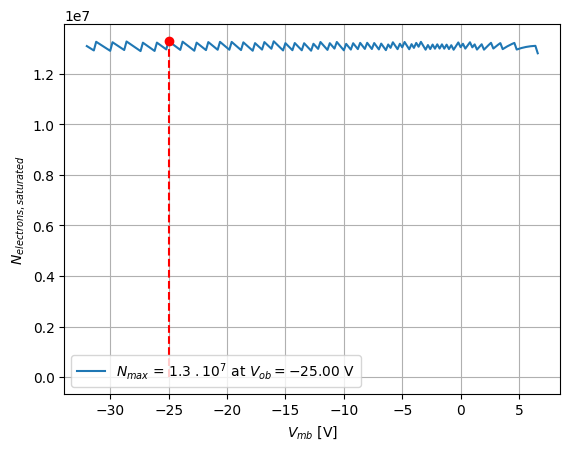

In [41]:
#-----------z component of the electric field (CGS) at the position of the electron layer (Eztil) and of the top electrode------------------#
for i in range(0, N+1):
    Eztil[i] = (phitil[position_of_electrons-1,i]-phitil[position_of_electrons,i])/hz
    Phitil[i] = phitil[position_of_electrons,i]
    

# --------- homogen. electric r-field at the el. layer (CGS) ------------ #
for i in range(0, N):
    Ertil[i] = (phitil[position_of_electrons,i]-phitil[position_of_electrons,i+1])/hr
    EztilTOP[i] = (phitil[M-1,i]-phitil[M,i])/hz

voltage = [struct['Vmb'] for struct in DataStruct]
N_electrons_list = [struct['N_electrons'] for struct in DataStruct]
N_electrons_list = np.array(N_electrons_list)

# Find the maximum number of electrons (useful only if you loaded staturated density profiles)
idx = np.argmax(N_electrons_list)
v_max = voltage[idx]
n_max = N_electrons_list[idx]
print('Vmb with the maximum saturated electron number:', v_max)

# Plot
# if you initially uploaded fixed N density profiles, the plot should be a horitzontal line with very small relative fluctuations
plt.plot(voltage, N_electrons_list, label=fr"$N_{{max}}$ = {(n_max*1e-7):.1f} $.10^7$ at $V_{{ob}} = {v_max:.2f}$ V")
plt.vlines(v_max, 0, n_max, color='red', linestyle='--', label='_nolegend_') 
plt.plot(v_max, n_max, 'ro')  

plt.xlabel('$V_{mb}$ [V]')
plt.ylabel('$N_{electrons, saturated}$')
plt.legend()
plt.grid(True)



## Calculate the plasmon frequencies and the impedance

In [42]:
# choose the RF frequency range for the impedance calculation
omega_vector = 2 * cp.pi * cp.linspace(119*1e6, 123*1e6, 401)

In [ ]:
print(len(omega_vector))
fileIndex = 0

# choose tau which determines the scaterring rate of the electrons
tau = 3.85363e-8

# initialization
I_Vec = cp.zeros(len(omega_vector), dtype = "complex")
I_Vec_start = cp.zeros(len(omega_vector), dtype = "complex")

fileIndex = 0
deltafunc = cp.eye(N+1,N+1)

E = cp.zeros((N, N), dtype = "complex")
ETest = cp.zeros((N, N), dtype = "complex")
D = cp.zeros((N, N), dtype = "complex")
F = cp.zeros((N, N), dtype = "complex")
H = cp.zeros((N, N), dtype = "complex")

EStart = cp.zeros((N, N), dtype = "complex")
DStart = cp.zeros((N, N), dtype = "complex")

sigma = cp.zeros(N, dtype = "complex")
b = cp.zeros(N, dtype = "complex")

density_AC = cp.zeros(N, dtype = "complex")

test1 = cp.zeros((N, N), dtype = "complex")
test2 = cp.zeros((N, N), dtype = "complex")

# Loop over each voltage
for v in v_loop:
    print(str((len(v_loop) - fileIndex))+ 'Iterations left')
    
    # ------- Find radius_of_electron_pool  -------- #
    density=cp.array(DataStruct[fileIndex]["density"])

    # hr * K = radius_of_electron_pool
    # with the notations of the calculations, K=m+1
    K = np.amin((np.nonzero(np.array(cp.asnumpy(density)) == 0))) 
    
    cp.copyto(E[0:K, 0:K], EStart[0:K, 0:K])
    cp.copyto(D[0:K, 0:K], DStart[0:K, 0:K])
    
    # -------- Calculate D (see Sec. V-B of the calculations that can be found here: the file Calculation_details.pdf at https://drive.google.com/drive/folders/1lC1xuzMQvBS7sev4N5r9cZi6F-KcE2N- )----------- #
    D[0:K,0:K]=deltafunc[0:K,0:K]*A[0:K]
        

    # -------- Calculate E (see Sec. V-B of the calculations) ----------- #
    # Only the coefficients in positions [0:K, 0:K] of the matrices E, D and F are used for the calculations of the modes 
    E[0:K, 0] = -1 * rdash[0]*density[0]*(dGr[K,0]*A[0:K]/A[K]-dGr[0:K,0])
    for j in range(0, K):
        E[j,1:K] = -1 * rdash[1:K]*density[1:K]*(dGr[K,1:K]*A[j]/A[K]-dGr[j,1:K])+rdash[0:K-1]*density[0:K-1]*(dGr[K,0:K-1]*A[j]/A[K]-dGr[j,0:K-1])

    cp.copyto(I_Vec, I_Vec_start)
    for omega_pt in range(0, len(omega_vector)):

        omega = omega_vector[omega_pt]

        # -------- Calculate sigma, the conductivity----------- #
        sigma[0:K] = cp.power(e, 2) * density[0:K] * tau/(mass * (1 - 1j * omega * tau))

        # -------- Calculate F----------- #
        F=cp.power(e, 2) * E * tau/(mass * (1 - 1j * omega * tau))

        # -------- Calculate b----------- #
        b[0] = rdash[0] * sigma[0] * Ertil[0]
        b[K-1] = -1 * rdash[K-2]*sigma[K-2]*Ertil[K-2]
        b[1:K-1] = rdash[1:K-1] * sigma[1:K-1] * Ertil[1:K-1] - rdash[0:K-2] * sigma[0:K-2] * Ertil[0:K-2]
        
        # -------- Calculate H----------- #
        H[0:K,0:K] = -1j * (omega * e/(2*cp.pi))*D[0:K,0:K]+F[0:K,0:K]
        
        #----------Calculate the densities ie the \delta n (cf calculations) ----------- #
        density_AC[0:K] = cp.dot((b[:K]),cp.linalg.inv((H[:K,:K])))

        # ------------------ use conservation of charge --------------------- #
        density_AC[K] = 0
        density_AC[K] -= cp.sum(A[0:K] * (density_AC[0:K])/A[K])
        # ------------------ out of pool --------------------- #
        density_AC[K+1:N] = 0


        EzTop =-1 * cp.dot(density_AC, dGzTOP)


        Q_AC=-cp.sum(A[0:int(N_Vib)+1]*EzTop[0:int(N_Vib)+1]/(4*cp.pi))
        # ------------------ calculate the impedance for a given Vmb and a given RF frequency--------------------- #
        I_Vec[omega_pt] = -1j * omega * Q_AC



    diagM, V = np.linalg.eig(2*np.pi*e/mass*np.dot(cp.asnumpy(E[0:K, 0:K]), np.linalg.inv(cp.asnumpy(D[0:K, 0:K]))))



    ind = np.argsort(diagM)
    d = np.sort(diagM)

    # choose the plasmons you want to store the frequencies of
    # you need : num_plasmons_to_store = len(plasmon_labels)
    plasmon_labels = ["First", "Second", "Third"]
    # change here the number of plasmons
    num_plasmons_to_store = 3

    
    # if you want to start by storing let's say second plasmon, change the range of the loop as well as the plasmon layers
    for i in range(num_plasmons_to_store):
        label = plasmon_labels[i] + "Plasmon"
        DataStruct[fileIndex][label] = np.sqrt(np.real(d[i])) / (2 * np.pi * 1e6)
    DataStruct[fileIndex]['Impedance'] = cp.copy(I_Vec)

    fileIndex += 1 # Increment the file   



401
194Iterations left
193Iterations left
192Iterations left
191Iterations left
190Iterations left
189Iterations left
188Iterations left
187Iterations left
186Iterations left
185Iterations left
184Iterations left
183Iterations left
182Iterations left
181Iterations left
180Iterations left
179Iterations left
178Iterations left
177Iterations left
176Iterations left
175Iterations left
174Iterations left
173Iterations left
172Iterations left
171Iterations left
170Iterations left
169Iterations left
168Iterations left
167Iterations left
166Iterations left
165Iterations left
164Iterations left
163Iterations left
162Iterations left
161Iterations left
160Iterations left
159Iterations left
158Iterations left
157Iterations left
156Iterations left
155Iterations left
154Iterations left
153Iterations left
152Iterations left
151Iterations left
150Iterations left
149Iterations left
148Iterations left
147Iterations left
146Iterations left
145Iterations left
144Iterations left
143Iterations left
142Itera

In [44]:
# creates vectors using stored data 
ImpedanceVector = []
num_plasmons_to_load=3
plasmon_vectors = {label: [] for label in plasmon_labels[:num_plasmons_to_load]}
VmbVector = []

for struct in DataStruct:
    VmbVector.append(struct['Vmb'])
    ImpedanceVector.append((cp.asnumpy(struct['Impedance'])))
    for label in plasmon_labels[:num_plasmons_to_load]:
        plasmon_vectors[label].append(struct[f"{label}Plasmon"])



0
1
2


<>:50: SyntaxWarning: invalid escape sequence '\e'
<>:50: SyntaxWarning: invalid escape sequence '\e'
C:\Users\riken\AppData\Local\Temp\ipykernel_59224\3663280339.py:50: SyntaxWarning: invalid escape sequence '\e'
  plt.title('$V_{ib}=$'+str(Vib)+'$ V , V_{ob}=$'+str(Vob)+' V , N = ' + str(N) + ', M = ' + str(M) + ', Position of Electrons = ' + str(position_of_electrons)+ f'$, \epsilon$ = {eps}', loc='center')


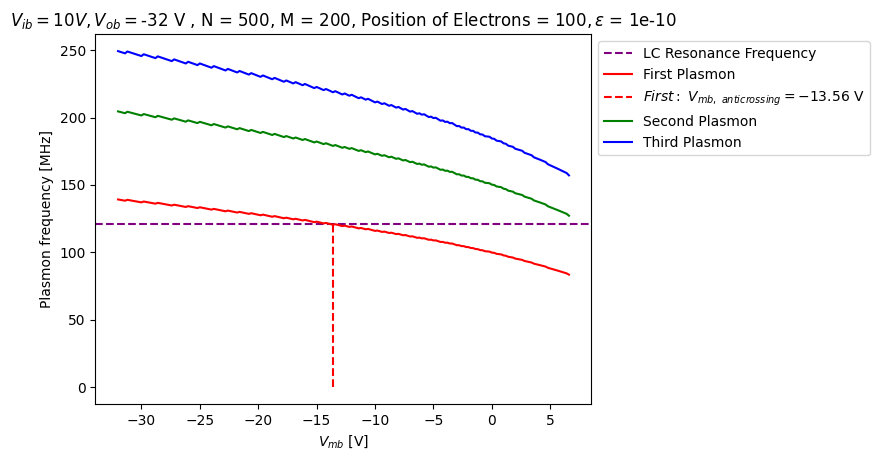

In [45]:
plt.xlabel('$V_{mb}$ [V]')
plt.ylabel('Plasmon frequency [MHz]')

LCResonanceFrequency = 120.945
plt.axhline(y = LCResonanceFrequency, linestyle = '--', color = 'purple', label = 'LC Resonance Frequency')

# needs to have the same number of elements as plasmon_labels
# define the colors for each plasmon
colors = ['r', 'g', 'b']

# Dictionnary to store splines for each plasmon
spline_plasmon = {}
spline_plot = {}

num_plasmons_to_plot = 3  

for i, name in zip(range(num_plasmons_to_plot), plasmon_labels):
    label = plasmon_labels[i]
    plt.plot(np.array(VmbVector),
             plasmon_vectors[label],
             color=colors[i],
             label=f"{label} Plasmon")
    
    # convert to numpy arrays for interpolation
    VmbVector = np.array(VmbVector)
    plasmon_vectors[label] = np.array(plasmon_vectors[label])
    idx = np.argsort(VmbVector)
    VmbVector_sorted = VmbVector[idx]
    plasmon_vectors_sorted = plasmon_vectors[label][idx]

    spline_plasmon[name] = itp.UnivariateSpline(
        np.array(VmbVector_sorted),
        np.array(plasmon_vectors_sorted) - LCResonanceFrequency,
        s=20
    )
    print(i)

    # look for the voltages where the plasmon frequency crosses the LC resonance frequency
    if len(spline_plasmon[name].roots()>1):
        v_anti_crossing=np.round(spline_plasmon[name].roots()[0],2)
        plt.vlines(spline_plasmon[name].roots()[0], 0, LCResonanceFrequency, linestyle = '--', color=colors[i], label=rf"${name}:\ V_{{mb,\ anticrossing}} = {v_anti_crossing}\ \mathrm{{V}}$")

    # creates a spline for plotting
    spline_plot[name] = itp.UnivariateSpline(
        np.array(VmbVector_sorted),
        np.array(plasmon_vectors_sorted),
        s=90
    )

plt.title('$V_{ib}=$'+str(Vib)+'$ V , V_{ob}=$'+str(Vob)+' V , N = ' + str(N) + ', M = ' + str(M) + ', Position of Electrons = ' + str(position_of_electrons)+ f'$, \epsilon$ = {eps}', loc='center')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

## Plot the colour map

kappa=0.3886341291731565
f_{LC}=129.58018005975157MHz
f_{R}=120.94592957478439MHz


<>:70: SyntaxWarning: invalid escape sequence '\G'
<>:87: SyntaxWarning: invalid escape sequence '\G'
<>:96: SyntaxWarning: invalid escape sequence '\G'
<>:70: SyntaxWarning: invalid escape sequence '\G'
<>:87: SyntaxWarning: invalid escape sequence '\G'
<>:96: SyntaxWarning: invalid escape sequence '\G'
C:\Users\riken\AppData\Local\Temp\ipykernel_59224\1813063545.py:70: SyntaxWarning: invalid escape sequence '\G'
  plt.colorbar(label='Im($\Gamma$)')
C:\Users\riken\AppData\Local\Temp\ipykernel_59224\1813063545.py:87: SyntaxWarning: invalid escape sequence '\G'
  plt.colorbar(label='Re($\Gamma$)')
C:\Users\riken\AppData\Local\Temp\ipykernel_59224\1813063545.py:96: SyntaxWarning: invalid escape sequence '\G'
  plt.colorbar(label='$|\Gamma|$')


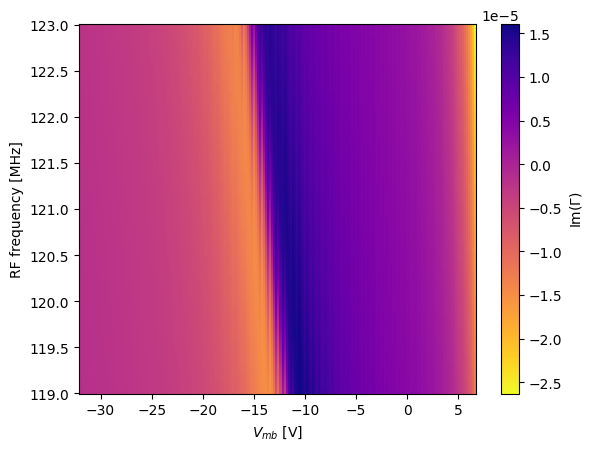

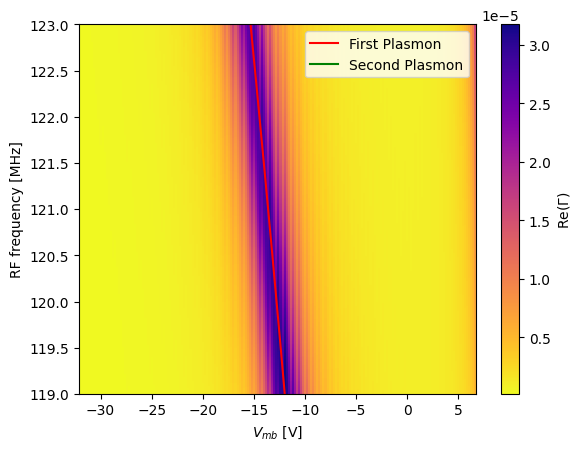

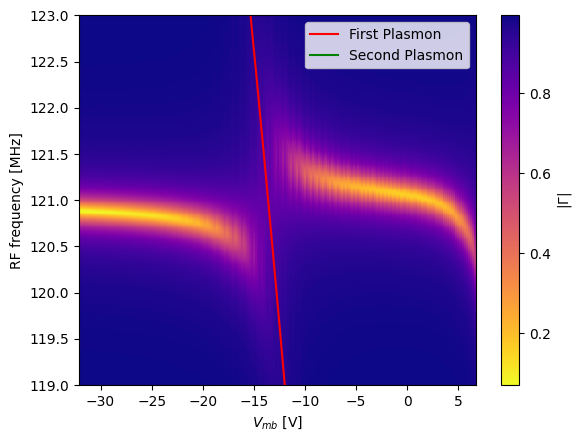

In [ ]:
f_LC=cp.asnumpy(omega_vector)/(2*np.pi)

# creates an array to store the real and imaginary parts of the impedance
Matrix_Imag = np.zeros((len(DataStruct), len(cp.asnumpy(DataStruct[0]['Impedance']))))

for i in range(0, len(DataStruct)):
    Matrix_Imag[i] = (np.imag(cp.asnumpy(DataStruct[i]['Impedance'])))

Matrix_Real = np.zeros((len(DataStruct), len(cp.asnumpy(DataStruct[0]['Impedance']))))

for i in range(0, len(DataStruct)):
    Matrix_Real[i] = (np.real(cp.asnumpy(DataStruct[i]['Impedance'])))

Z0=50 

# values from the article: https://doi.org/10.48550/arXiv.2504.09890
Cc=0.315083*1e-12
L=708*1e-9
C=2.130737*1e-12
Res=321.98*1e3
omegaLC = 1/np.sqrt(L*C)
omegaR=np.sqrt(C/(C+Cc))*omegaLC
fr=omegaR/(2*np.pi)
angular_kappa=(1/Res + ((omegaR*Cc*Z0)**2)/Z0 )/(C+Cc)
print('kappa='+str((angular_kappa/(2*np.pi))*1e-6))





print('f_{LC}='+str(1e-6*omegaLC/(2*cp.pi))+'MHz') 
print('f_{R}='+str(1e-6*fr)+'MHz') 

# see Sec V of the calculations for the derivations of the formulas
Q0=omegaLC*C*Res

OneOverZp=1j * np.matrix(Matrix_Imag).T/Vit_AC/9e11 + np.matrix(Matrix_Real).T/Vit_AC/9e11

phase=-1
ZL=Res/(1+phase*1j*Q0*(cp.asnumpy(omega_vector)/omegaLC-omegaLC/cp.asnumpy(omega_vector)))


OneOverZL = np.zeros((len(DataStruct), len(ZL)), dtype = "complex")
for i in range(0, len(DataStruct)):
    OneOverZL[i] = 1/ZL


Z_L_new = 1/(np.matrix(OneOverZL).transpose() + np.matrix(OneOverZp))
# if you zant to check the plot without the plasmon
# Z_L_new = 1/(np.matrix(OneOverZL).transpose() )

CouplingMatrix = np.zeros((len(DataStruct), len(omega_vector)), dtype = "complex")
for i in range(0, len(DataStruct)):
    CouplingMatrix[i] = 1/(phase*1j*cp.asnumpy(omega_vector)*Cc)

Z_l = np.matrix(CouplingMatrix).transpose()+ np.matrix(Z_L_new)


Gamma = (Z_l - Z0)/(Z_l + Z0)


#---------------- plot ------------------#


plasmon_labels = ["First", "Second"]
colors = ['r', 'g']

plt.pcolormesh(np.array(VmbVector), cp.asnumpy(omega_vector)/(2*np.pi*1e6), (np.imag(OneOverZp)), shading="auto", cmap = 'plasma_r')
plt.colorbar(label='Im($\Gamma$)')
plt.xlabel('$V_{mb}$ [V]')
plt.ylabel('RF frequency [MHz]')
plt.show()


plt.pcolormesh(np.array(VmbVector), cp.asnumpy(omega_vector)/(2*np.pi*1e6), (np.real(OneOverZp)), shading="auto", cmap = 'plasma_r')



for color, name in zip(colors,plasmon_labels):
    plt.plot(np.array(VmbVector), spline_plot[name](np.array(VmbVector)), color = color, label = name+' Plasmon')

plt.xlabel('$V_{mb}$ [V]')
plt.ylabel('RF frequency [MHz]')
plt.ylim((119, 123))  
plt.colorbar(label='Re($\Gamma$)')
plt.legend()
plt.show()



Gamma=np.asarray(Gamma)
plt.pcolormesh(np.array(VmbVector), cp.asnumpy(omega_vector)/(2*np.pi*1e6), np.abs(Gamma), shading="auto", cmap = 'plasma_r')
plt.colorbar(label='$|\Gamma|$')
plt.xlabel('$V_{mb}$ [V]')
plt.ylabel('RF frequency [MHz]')

for color, name in zip(colors,plasmon_labels):
    plt.plot(np.array(VmbVector), spline_plot[name](np.array(VmbVector)), color = color, label = name+' Plasmon')

plt.ylim((119, 123))  

plt.legend()
plt.show()



## Calculate the modes

-13.600000000000065


<Figure size 800x500 with 0 Axes>

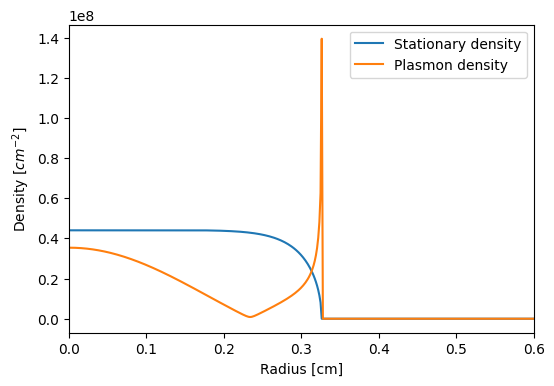

C:\Users\riken\AppData\Local\Temp\ipykernel_59224\657970015.py:112: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm2 = ax2.pcolormesh(X, Y, Z,


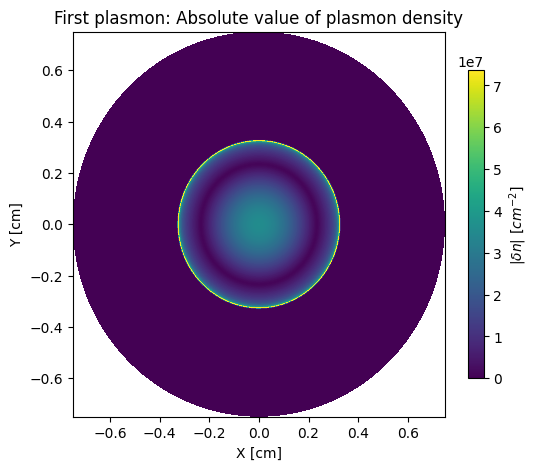

C:\Users\riken\AppData\Local\Temp\ipykernel_59224\657970015.py:126: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm3 = ax3.pcolormesh(X, Y, Z_imag,


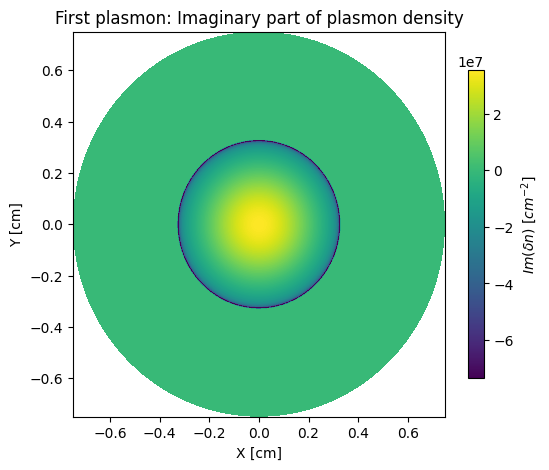

C:\Users\riken\AppData\Local\Temp\ipykernel_59224\657970015.py:142: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm4 = ax4.pcolormesh(X, Y, Z_real,


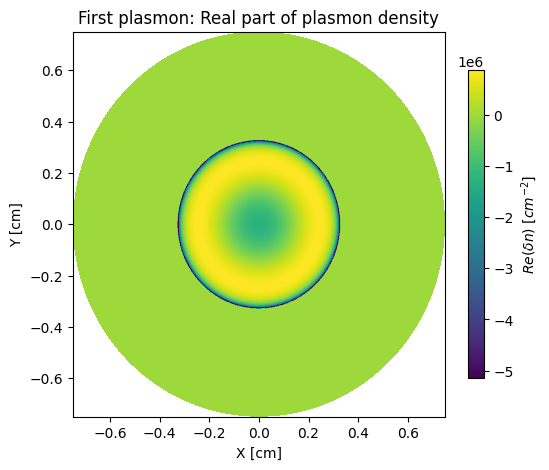

In [57]:
from scipy.ndimage import gaussian_filter
%matplotlib inline

# choose the plasmon number you want to plot
# the frequency of this plasmon needs to cross the LC resonance frequency
Plasmon_number='First'
plt.figure(figsize=(8, 5))

# choose the resonance voltage
voltage=spline_plasmon[Plasmon_number].roots()[0]


fileIndex = np.argmin(np.abs(np.array(VmbVector)-voltage))
print(VmbVector[fileIndex])
plasmon_frequency=DataStruct[fileIndex][Plasmon_number + 'Plasmon']*2*np.pi*1e6
omega = plasmon_frequency


tau = 3.85363e-8
deltafunc = cp.eye(N+1,N+1)
E = cp.zeros((N, N), dtype = "complex")
D = cp.zeros((N, N), dtype = "complex")
F = cp.zeros((N, N), dtype = "complex")
H = cp.zeros((N, N), dtype = "complex")
sigma = cp.zeros(N, dtype = "complex")
b = cp.zeros(N, dtype = "complex")
density_AC = cp.zeros(N, dtype = "complex")



# ------- Find radius_of_electron_pool  -------- #
density=cp.array(DataStruct[fileIndex]["density"])
# hr * K = radius_of_electron_pool
# with the notations of the calculations, K=m+1
K = np.amin((np.nonzero(np.array(cp.asnumpy(density)) == 0))) 

cp.copyto(E[0:K, 0:K], EStart[0:K, 0:K])
cp.copyto(D[0:K, 0:K], DStart[0:K, 0:K])

#  see Sec. V-B of the calculations for the derivations of those expressions
# -------- Calculate D ----------- #
D[0:K,0:K]=deltafunc[0:K,0:K]*A[0:K]
rdash=cp.array(rdash)


# -------- Calculate E ----------- #
# Only the coefficients in positions [0:K, 0:K] of the matrices E, D and F are used for the calculations of the modes 
E[0:K, 0] = -1 * rdash[0]*density[0]*(dGr[K,0]*A[0:K]/A[K]-dGr[0:K,0])
for j in range(0, K):
    E[j,1:K] = -1 * rdash[1:K]*density[1:K]*(dGr[K,1:K]*A[j]/A[K]-dGr[j,1:K])+rdash[0:K-1]*density[0:K-1]*(dGr[K,0:K-1]*A[j]/A[K]-dGr[j,0:K-1])

# -------- Calculate sigma, the conductivity----------- #

sigma[0:K] = cp.power(e, 2) * density[0:K] * tau/(mass * (1 - 1j * omega * tau))

# -------- Calculate F  ----------- #
F=cp.power(e, 2) * E * tau/(mass * (1 - 1j * omega * tau))

# -------- Calculate b----------- #
b[0] = rdash[0] * sigma[0] * Ertil[0]
b[K-1] = -1 * rdash[K-2]*sigma[K-2]*Ertil[K-2]
b[1:K-1] = rdash[1:K-1] * sigma[1:K-1] * Ertil[1:K-1] - rdash[0:K-2] * sigma[0:K-2] * Ertil[0:K-2]

    
# -------- Calculate H----------- #
H[0:K,0:K] = -1j * (omega * e/(2*cp.pi))*D[0:K,0:K]+F[0:K,0:K]
    
#----------Calculate the densities ie the \delta n  ----------- #
density_AC[0:K] = cp.dot((b[:K]),cp.linalg.inv((H[:K,:K])))


# # ------------------ use conservation of charge --------------------- #
density_AC[K] -= cp.sum(A[0:K] * (density_AC[0:K])/A[K])
# ------------------ out of the pool --------------------- #
density_AC[K+1:N] = 0


theta = np.linspace(0, 4 * np.pi, 10000)
R, Theta = np.meshgrid(cp.asnumpy(rdash[0:N]), theta)


X = R * np.cos(Theta)
Y = R * np.sin(Theta)


density_AC=cp.asnumpy(density_AC)
density=cp.asnumpy(density)
Z = np.tile(np.abs(density_AC[0:N]), (len(theta), 1))
Z_real= np.tile(np.real(density_AC[0:N]), (len(theta), 1))
Z_imag= np.tile(np.imag(density_AC[0:N]), (len(theta), 1))



Z = gaussian_filter(Z, sigma=1)
Z_real = gaussian_filter(Z_real, sigma=1)
Z_imag = gaussian_filter(Z_imag, sigma=1)   

# 2D plot of the densities 
fig1, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(cp.asnumpy(rdash[0:N]), density[0:N],      label='Stationary density')
ax1.plot(cp.asnumpy(rdash[0:N]), np.abs(density_AC[0:N]), label='Plasmon density')
ax1.set_xlim(0, 0.6)
ax1.set_xlabel('Radius [cm]')
ax1.set_ylabel('Density $[cm^{-2}]$')
ax1.legend()
plt.show()



# 3D plot of the absolute value of the plasmon density
fig2, ax2 = plt.subplots(figsize=(6,5))
pcm2 = ax2.pcolormesh(X, Y, Z,
                      shading='nearest',
                      cmap='viridis')
ax2.set_title(f'{Plasmon_number} plasmon: Absolute value of plasmon density')
ax2.set_xlabel('X [cm]')
ax2.set_ylabel('Y [cm]')
fig2.colorbar(pcm2,
               ax=ax2,
               shrink=0.8,
               label=r'$|\delta n|\ [cm^{-2}]$')
plt.show()

# 3D plot of the imaginary part of the plasmon density
fig3, ax3 = plt.subplots(figsize=(6,5))
pcm3 = ax3.pcolormesh(X, Y, Z_imag,
                      shading='nearest',
                      cmap='viridis')
ax3.set_title(f'{Plasmon_number} plasmon: Imaginary part of plasmon density')
ax3.set_xlabel('X [cm]')
ax3.set_ylabel('Y [cm]')
fig3.colorbar(pcm3,
               ax=ax3,
               shrink=0.8,
               label=r'$Im(\delta n)\ [cm^{-2}]$')
plt.show()



# 3D plot of the real part of the plasmon density
fig4, ax4 = plt.subplots(figsize=(6,5))
pcm4 = ax4.pcolormesh(X, Y, Z_real,
                      shading='nearest',
                      cmap='viridis')
ax4.set_title(f'{Plasmon_number} plasmon: Real part of plasmon density')
ax4.set_xlabel('X [cm]')
ax4.set_ylabel('Y [cm]')
fig4.colorbar(pcm4,
               ax=ax4,
               shrink=0.8,
               label=r'$Re(\delta n)\ [cm^{-2}]$')
plt.show()

# $V_{ob}$ sweep 

## Load the density functions

<>:103: SyntaxWarning: invalid escape sequence '\e'
<>:103: SyntaxWarning: invalid escape sequence '\e'
C:\Users\riken\AppData\Local\Temp\ipykernel_59224\2226113103.py:103: SyntaxWarning: invalid escape sequence '\e'
  ax.set_title(f'Density profile for different Vob potentials ($\epsilon={eps} ,N={N}, M={M}$)')


<Figure size 640x480 with 0 Axes>

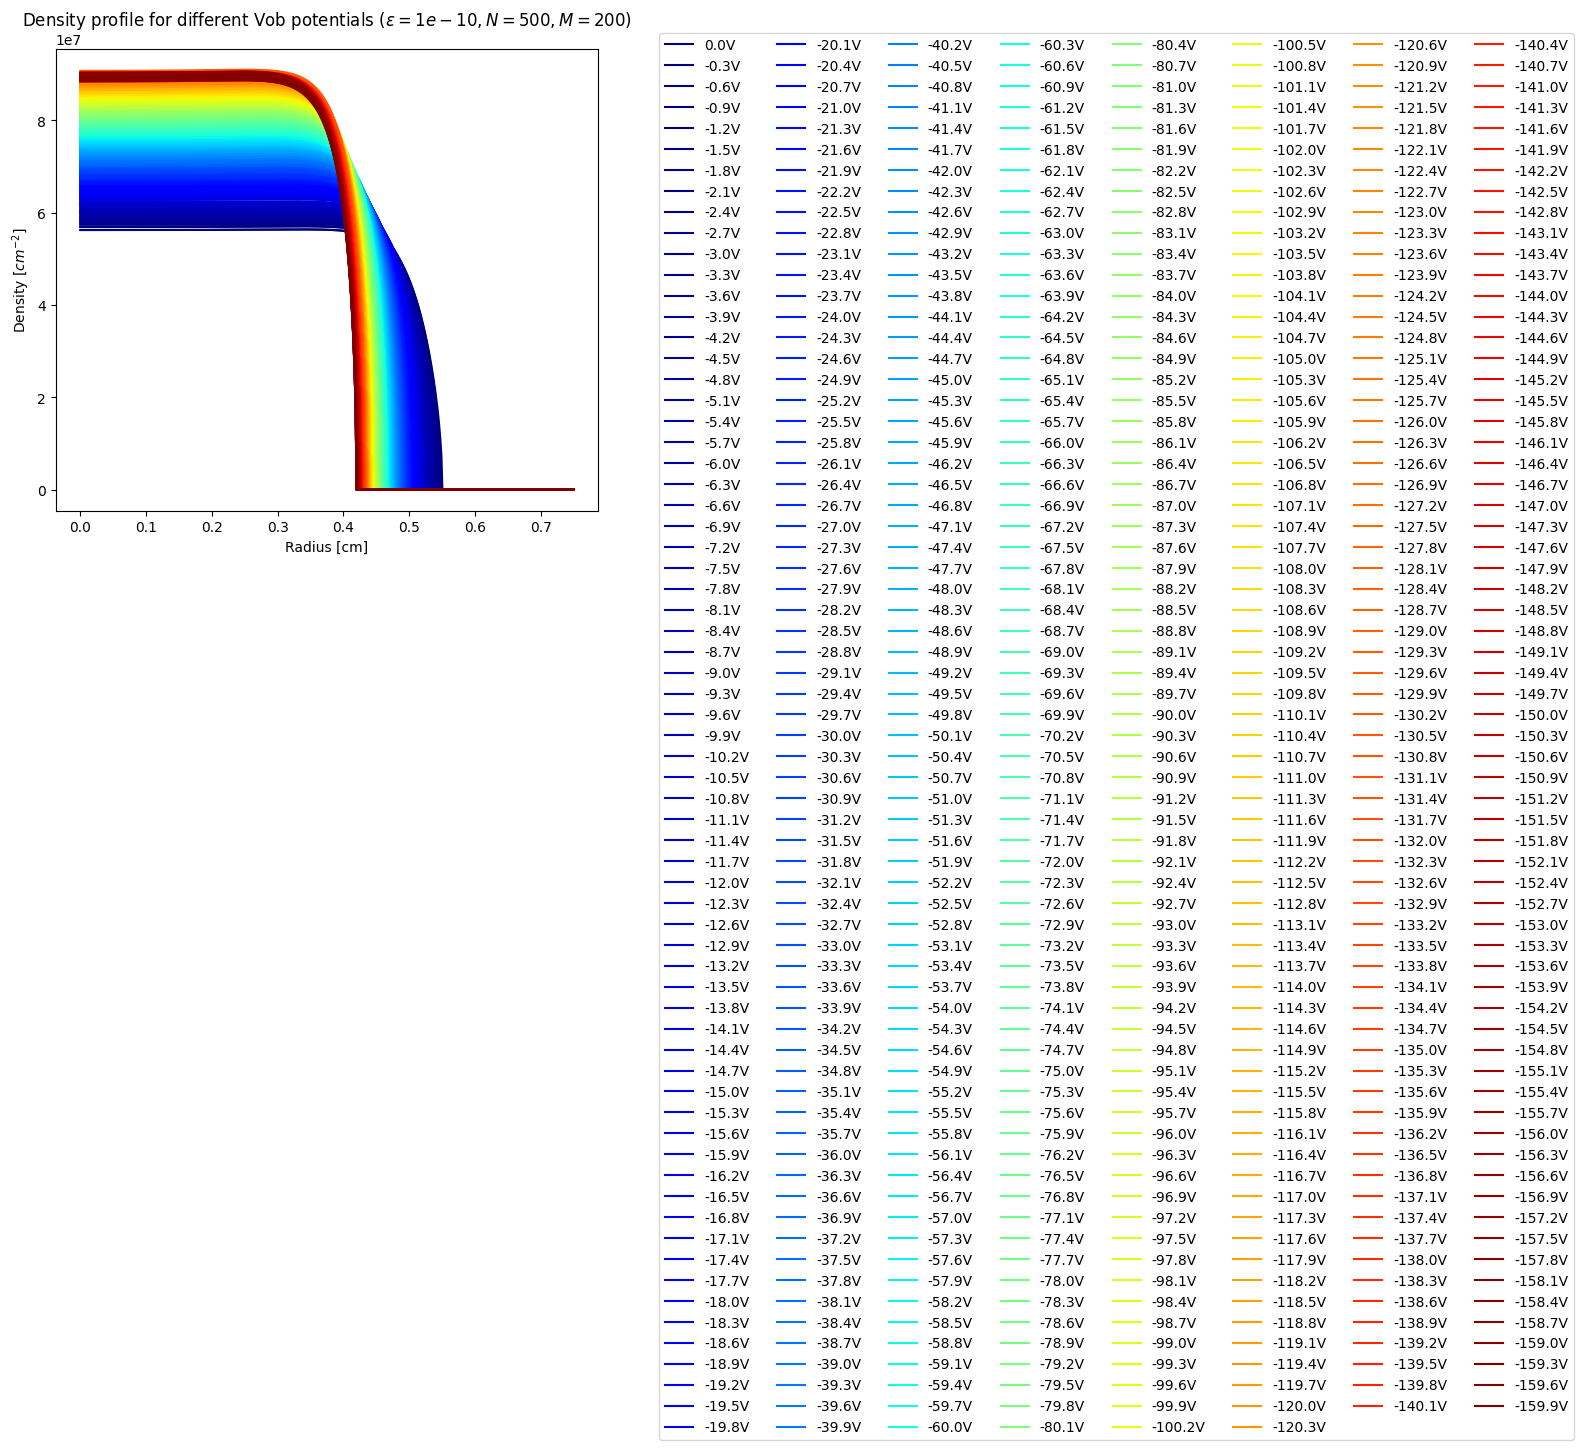

In [ ]:
Vib=17
Vmb=17

# choose the same parameters as for density calculation 
# so that the loaded files do exist
# pay attention to the last voltage 
startVob = 0
endVob = -160
stepVob = -0.3
# Calculate the number of files (steps) to determine the colormap size
v_loop = np.arange(startVob, endVob, stepVob)
numFiles = len(v_loop)
 
# Generate a colormap
colormap = plt.jet()



column_names = ["rcm", "densitycm2"]
column_types = {"rcm": "float64", "densitycm2": "float64"}


# creates a label for each plotted line
legLabels = [None] * int(numFiles)

# Create a list to store the data for each file
DataStruct = [{} for _ in range(numFiles)]

A = cp.zeros(N+1)
rdash = cp.zeros(N+1)

A[0] = cp.pi * cp.power(hr/2, 2)
A[N] = cp.pi * (N + 1 - 5/4) * cp.power(hr, 2)
A[1:N] = 2 * cp.pi * (cp.arange(2, N+1) - 1) * cp.power(hr, 2)

rdash[0:N+1] = (cp.arange(0, N+1) + 1/2) * hr


colors = plt.cm.jet(np.linspace(0,1,len(v_loop)))
# Loop through each file
fileIndex = 0 # Initialize a counter for the file index
fig, ax = plt.subplots(1,1, figsize=(7,6))


# here we consider that the initial total number of electrons (for Vob=0V) is 0.8*Nsaturated (allows for better agreement with the experiment)
# the saturated number of electrons as a function of Vob having this profile: file saturated_number_electrons=f(Vob).png at  https://drive.google.com/drive/folders/1mCcsGUvq4owEBdB_-kIfpP9CmeoYaN83 
# and the sweep being decreasing, we neeed to use fixed N density profiles for the first 442 voltages 
for v in v_loop[:442]:
    # Generate the filename
    Vob_str = f"{v:.1f}".replace(".", "p")
    # if np.abs(v) < 0.01:
    #     Vob_str = f"{-v:.1f}".replace(".", "p")

    # define the path to the files
    # if you downloaded the folder Vmbsweep from the drive: https://drive.google.com/drive/folders/1lC1xuzMQvBS7sev4N5r9cZi6F-KcE2N-
    # and that you put it in one of your folders on your desktop on Windows, the folder path should be:
    folder =f"C:/Users/username/Desktop/foldername/VobSweep/Vib17V_Vmb17V"
    filename = f"fixed_electron_number_density/fixedN_Vib{Vib}_Vmb{Vmb}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"

    file = np.load(folder+filename, allow_pickle=True)
    
    DataStruct[fileIndex] = {
        'r': file[0],
        'density': file[1],
        'Vob': v,
        'N_electrons': np.sum(cp.asnumpy(A)*file[1])
    }  

    # Plot density vs r using the color corresponding to the file index    
    ax.plot(DataStruct[fileIndex]['r'], DataStruct[fileIndex]['density'], color=colors[fileIndex])

    # Generate label for this line and store it
    legLabels[fileIndex] = f"{DataStruct[fileIndex]['Vob']:.1f}V"
    fileIndex += 1 # Increment the file index

for v in v_loop[442:]:
    # Generate the filename
    Vob_str = f"{v:.1f}".replace(".", "p")
    # if np.abs(v) < 0.01:
    #     Vob_str = f"{-v:.1f}".replace(".", "p")
    
    # define the path to the files
    filename = f"saturated_density/saturated_density_Vib{Vib}_Vmb{Vmb}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    file = np.load(folder+filename, allow_pickle=True)
    
    DataStruct[fileIndex] = {
        'r': file[0],
        'density': file[1],
        'Vob': v,
        'N_electrons': np.sum(cp.asnumpy(A)*file[1])
    }  

    # Plot density vs r using the color corresponding to the file index    
    ax.plot(DataStruct[fileIndex]['r'], DataStruct[fileIndex]['density'], color=colors[fileIndex])

    # Generate label for this line and store it
    legLabels[fileIndex] = f"{DataStruct[fileIndex]['Vob']:.1f}V"
    fileIndex += 1 # Increment the file index




ax.set_xlabel('Radius [cm]')
ax.set_ylabel('Density $[cm^{-2}]$')
ax.set_title(f'Density profile for different Vob potentials ($\epsilon={eps} ,N={N}, M={M}$)')
ax.legend(legLabels, ncol=8, bbox_to_anchor=(1.1, 1.05))

plt.show()



## Define function to calculate $\tilde \Phi$ the potential created by the AC voltage

In [63]:
iRange = cp.arange(2, N+1)
# function to efficiently copy a 2D array 
@njit(parallel=True, fastmath=True)
def copyAr2D(dst, src):
    for i in prange(src.shape[0]):
        for j in range(src.shape[1]):
            dst[i, j] = src[i, j]


fitilStart = cp.full((M+1,N+1),-1/300)
fitil = cp.full((M+1,N+1),-1/300)
aStart = cp.zeros((M-1, N+1))
a = cp.zeros((M-1, N+1))

# function to calculate the potential created by the AC voltage
def fitilSOLUT(R,H,N,M,Vib,Vmb,Vob,N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr):
    cp.copyto(fitil, fitilStart)


    # --------------- boundary conditions on the electrodes ----------------- #
    fitil[0, 0:int(N_Vib)] = Vib
    fitil[0, int(N_Vib):int(N_Vmb)] = Vmb
    fitil[0, int(N_Vmb):int(N_Vob)] = Vob
    fitil[0, int(N_Vob):] = Vr
        
    fitil[M, 0:int(N_Vit)] = Vit
    fitil[M, int(N_Vit):int(N_Vmt)] = Vmt
    fitil[M, int(N_Vmt):int(N_Vot)] = Vot
    fitil[M, int(N_Vot):] = Vr
    
      
    
    fitil[:, N] = Vr
    
    
    # ---------------- relaxation for homogenious solution ------------------ #
    max_err= 1
    #err = np.zeros((M+1, N+1))
    
    count = 0
    errHere = 1e-10
    print(count)
    cp.copyto(a, aStart)
    while (max_err > errHere):

        count += 1
        if(count % 10000 == 0):
            print(max_err)

        cp.copyto(a, fitil[1:M, 0:N+1])
        fitil[1:M, 0] = (4 * (hz/hr) * fitil[1:M, 1] + (hr/hz) * fitil[0:M-1, 0] + (hr/hz) * fitil[2:M+1, 0])/(4 * hz/hr + 2 * hr/hz)

        fitil[1:M, 1:N] = ((iRange - 1/2 - 1) * (hz/hr) * fitil[1:M, 0:N-1] + (iRange + 1/2 - 1) * (hz/hr) * fitil[1:M, 2:N+1] + (iRange-1) * (hr/hz) * fitil[0:M-1, 1:N] + (iRange-1) * (hr/hz) * fitil[2:M+1, 1:N])/(2 * (iRange-1) * (hz/hr + hr/hz))
       
        max_err = np.amax(cp.abs(fitil[1:M, 0:N+1] - a))

    return fitil
    

## Calculate $\tilde \Phi$ created by the AC voltage

In [64]:
Vib_AC=0/300
Vmb_AC=0/300
Vob_AC=0/300
Vit_AC = 1/300
Vmt_AC=0/300
Vot_AC=0/300

Vr=0

phitil = fitilSOLUT(R,H,N,M,Vib_AC,Vmb_AC,Vob_AC,N_Vib,N_Vmb,Vit_AC,Vmt_AC,Vot_AC,N_Vit,N_Vmt,N_Vot, N_Vob,Vr)


Eztil = cp.zeros(N+1)

Phitil = cp.zeros(N+1)
Ertil = cp.zeros(N)
EztilTOP = cp.zeros(N)

0
2.3196415137533358e-07
9.842301381042008e-08
4.1640159470024765e-08
1.752132549812102e-08
7.349699745074628e-09
3.0786157666131547e-09
1.2884192443409631e-09
5.386847313701426e-10
2.2494479564628966e-10


## Calculate the fields and the total number of electrons

Vob with the maximum saturated electron number: -117.89999999999999


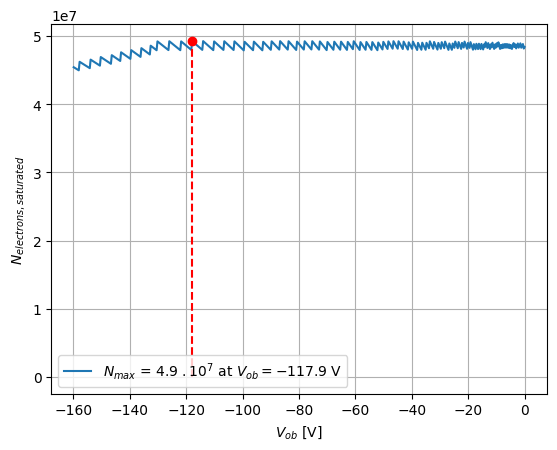

In [ ]:
#-----------z component of the electric field (CGS) at the position of the electron layer (Eztil) and of the top electrode------------------#
for i in range(0, N+1):
    Eztil[i] = (phitil[position_of_electrons-1,i]-phitil[position_of_electrons,i])/hz
    Phitil[i] = phitil[position_of_electrons,i]
    

# --------- homogen. electric r-field at the el. layer (CGS) ------------ #
for i in range(0, N):
    Ertil[i] = (phitil[position_of_electrons,i]-phitil[position_of_electrons,i+1])/hr
    EztilTOP[i] = (phitil[M-1,i]-phitil[M,i])/hz

voltage = [struct['Vob'] for struct in DataStruct]
N_electrons_list = [struct['N_electrons'] for struct in DataStruct]
N_electrons_list = np.array(N_electrons_list)




# Find maximum
idx = np.argmax(N_electrons_list)
v_max = voltage[idx]
n_max = N_electrons_list[idx]
print('Vob with the maximum saturated electron number:', v_max)

# Plot
plt.plot(voltage, N_electrons_list, label=fr"$N_{{max}}$ = {(n_max*1e-7):.1f} $.10^7$ at $V_{{ob}} = {v_max:.1f}$ V")
plt.vlines(v_max, 0, n_max, color='red', linestyle='--', label='_nolegend_')  
plt.plot(v_max, n_max, 'ro')  # highlight the max point

plt.xlabel('$V_{ob}$ [V]')
plt.ylabel('$N_{electrons, saturated}$')
plt.legend()
plt.grid(True)
    



## Calculate the plasmon frequencies and the impedance

In [85]:
omega_vector = 2 * cp.pi * cp.linspace(110*1e6, 130*1e6, 401)

In [ ]:
print(len(omega_vector))
fileIndex = 0


# tau obtained from the fit of the experimental data
tau =4.039465e-8


# initialization
I_Vec = cp.zeros(len(omega_vector), dtype = "complex")
I_Vec_start = cp.zeros(len(omega_vector), dtype = "complex")

fileIndex = 0
deltafunc = cp.eye(N+1,N+1)

E = cp.zeros((N, N), dtype = "complex")
ETest = cp.zeros((N, N), dtype = "complex")
D = cp.zeros((N, N), dtype = "complex")
F = cp.zeros((N, N), dtype = "complex")
H = cp.zeros((N, N), dtype = "complex")

EStart = cp.zeros((N, N), dtype = "complex")
DStart = cp.zeros((N, N), dtype = "complex")

sigma = cp.zeros(N, dtype = "complex")
b = cp.zeros(N, dtype = "complex")

density_AC = cp.zeros(N, dtype = "complex")

test1 = cp.zeros((N, N), dtype = "complex")
test2 = cp.zeros((N, N), dtype = "complex")

for v in v_loop:
    print(str((len(v_loop) - fileIndex))+ 'Iterations left')
    
    # ------- Find radius_of_electron_pool  -------- #  
    density=cp.array(DataStruct[fileIndex]["density"])

    # hr * K = radius_of_electron_pool
    # with the notations of the calculations, K=m+1
    K = np.amin((np.nonzero(np.array(cp.asnumpy(density)) == 0))) 
    
    cp.copyto(E[0:K, 0:K], EStart[0:K, 0:K])
    cp.copyto(D[0:K, 0:K], DStart[0:K, 0:K])
    
    # -------- Calculate D----------- #
    # See Sec V-B of the calculations for the derivations of those expressions
    D[0:K,0:K]=deltafunc[0:K,0:K]*A[0:K]
        

    # -------- Calculate E ----------- #
    # Only the coefficients in positions [0:K, 0:K] of the matrices E, D and F are used for the calculations of the modes 

    E[0:K, 0] = -1 * rdash[0]*density[0]*(dGr[K,0]*A[0:K]/A[K]-dGr[0:K,0])
    for j in range(0, K):
        E[j,1:K] = -1 * rdash[1:K]*density[1:K]*(dGr[K,1:K]*A[j]/A[K]-dGr[j,1:K])+rdash[0:K-1]*density[0:K-1]*(dGr[K,0:K-1]*A[j]/A[K]-dGr[j,0:K-1])

    cp.copyto(I_Vec, I_Vec_start)
    for omega_pt in range(0, len(omega_vector)):

        omega = omega_vector[omega_pt]

        # -------- Calculate sigma, the conductivity----------- #
        sigma[0:K] = cp.power(e, 2) * density[0:K] * tau/(mass * (1 - 1j * omega * tau))

        # -------- Calculate F----------- #
        F=cp.power(e, 2) * E * tau/(mass * (1 - 1j * omega * tau))

        # -------- Calculate b----------- #
        b[0] = rdash[0] * sigma[0] * Ertil[0]
        b[K-1] = -1 * rdash[K-2]*sigma[K-2]*Ertil[K-2]
        b[1:K-1] = rdash[1:K-1] * sigma[1:K-1] * Ertil[1:K-1] - rdash[0:K-2] * sigma[0:K-2] * Ertil[0:K-2]

        
        # -------- Calculate H----------- #
        H[0:K,0:K] = -1j * (omega * e/(2*cp.pi))*D[0:K,0:K]+F[0:K,0:K]
        
        #----------Calculate the densities ie the \delta n (cf calculations) ----------- #
        density_AC[0:K] = cp.dot((b[:K]),cp.linalg.inv((H[:K,:K])))
        # # ------------------ use conservation of charge --------------------- #
        density_AC[K] = 0
        density_AC[K] -= cp.sum(A[0:K] * (density_AC[0:K])/A[K])
        # ------------------ out of pool --------------------- #
        density_AC[K+1:N] = 0

        #-----------MODIF-----------------#
        #possible modif: EzTop = EztilTOP-1 * cp.dot(density_AC, dGzTOP)
        EzTop =-1 * cp.dot(density_AC, dGzTOP)



        Q_AC=-cp.sum(A[0:int(N_Vib)+1]*EzTop[0:int(N_Vib)+1]/(4*cp.pi))


        I_Vec[omega_pt] = -1j * omega * Q_AC


    diagM, V = np.linalg.eig(2*np.pi*e/mass*np.dot(cp.asnumpy(E[0:K, 0:K]), np.linalg.inv(cp.asnumpy(D[0:K, 0:K]))))
    ind = np.argsort(diagM)
    d = np.sort(diagM)

    plasmon_labels = ["First", "Second", "Third"]
    # change here the number of plasmons
    num_plasmons_to_store = 3


    for i in range(num_plasmons_to_store):
        label = plasmon_labels[i] + "Plasmon"
        DataStruct[fileIndex][label] = np.sqrt(np.real(d[i])) / (2 * np.pi * 1e6)
    DataStruct[fileIndex]['Impedance'] = cp.copy(I_Vec)

    fileIndex += 1 # Increment the file   




401
534Iterations left
533Iterations left
532Iterations left
531Iterations left
530Iterations left
529Iterations left
528Iterations left
527Iterations left
526Iterations left
525Iterations left
524Iterations left
523Iterations left
522Iterations left
521Iterations left
520Iterations left
519Iterations left
518Iterations left
517Iterations left
516Iterations left
515Iterations left
514Iterations left
513Iterations left
512Iterations left
511Iterations left
510Iterations left
509Iterations left
508Iterations left
507Iterations left
506Iterations left
505Iterations left
504Iterations left
503Iterations left
502Iterations left
501Iterations left
500Iterations left
499Iterations left
498Iterations left
497Iterations left
496Iterations left
495Iterations left
494Iterations left
493Iterations left
492Iterations left
491Iterations left
490Iterations left
489Iterations left
488Iterations left
487Iterations left
486Iterations left
485Iterations left
484Iterations left
483Iterations left
482Itera

In [95]:
# Initialize empty arrays
ImpedanceVector = []
plasmon_labels = ["First", "Second", "Third"]
num_plasmons_to_load = 3  


plasmon_vectors = {label: [] for label in plasmon_labels[:num_plasmons_to_load]}
VobVector = []

# store the data from DataStruct into vectors
for struct in DataStruct:
    VobVector.append(struct['Vob'])
    ImpedanceVector.append((cp.asnumpy(struct['Impedance'])))
    for label in plasmon_labels[:num_plasmons_to_load]:
        plasmon_vectors[label].append(struct[f"{label}Plasmon"])

0
1
2


<>:49: SyntaxWarning: invalid escape sequence '\e'
<>:49: SyntaxWarning: invalid escape sequence '\e'
C:\Users\riken\AppData\Local\Temp\ipykernel_59224\2795303952.py:49: SyntaxWarning: invalid escape sequence '\e'
  plt.title('$V_{ib}=$'+str(Vib)+'$ V , V_{mb}=$'+str(Vmb)+' V , N = ' + str(N) + ', M = ' + str(M) + ', Position of Electrons = ' + str(position_of_electrons)+ f'$, \epsilon$ = {eps}', loc='center')


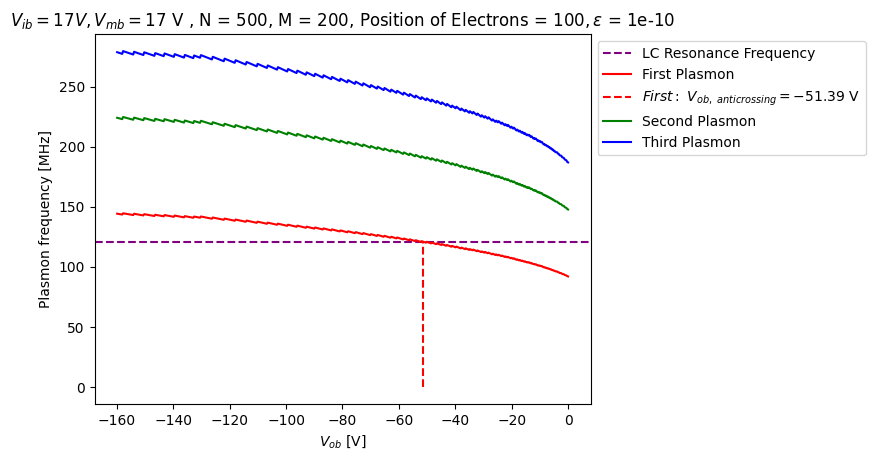

In [96]:
plt.xlabel('$V_{ob}$ [V]')
plt.ylabel('Plasmon frequency [MHz]')

LCResonanceFrequency = 120.945
plt.axhline(y = LCResonanceFrequency, linestyle = '--', color = 'purple', label = 'LC Resonance Frequency')

# choose a color for each plot of plasmon frequencies
colors = ['r', 'g', 'b']

# Dictionnary to store splines for each plasmon
spline_plasmon = {}
spline_plot = {}

num_plasmons_to_plot = 3 

for i, name in zip(range(num_plasmons_to_plot), plasmon_labels):
    label = plasmon_labels[i]
    plt.plot(np.array(VobVector),
             plasmon_vectors[label],
             color=colors[i],
             label=f"{label} Plasmon")
    
    # convert to numpy arrays for interpolation
    VobVector = np.array(VobVector)
    plasmon_vectors[label] = np.array(plasmon_vectors[label])
    idx = np.argsort(VobVector)
    VobVector_sorted = VobVector[idx]
    plasmon_vectors_sorted = plasmon_vectors[label][idx]

    spline_plasmon[name] = itp.UnivariateSpline(
        np.array(VobVector_sorted),
        np.array(plasmon_vectors_sorted) - LCResonanceFrequency,
        s=20
    )
    print(i)

    # look for the voltages where the plasmon frequency crosses the LC resonance frequency
    if len(spline_plasmon[name].roots()>1):
        v_anti_crossing=np.round(spline_plasmon[name].roots()[0],2)
        plt.vlines(spline_plasmon[name].roots()[0], 0, LCResonanceFrequency, linestyle = '--', color=colors[i], label=rf"${name}:\ V_{{ob,\ anticrossing}} = {v_anti_crossing}\ \mathrm{{V}}$")


    spline_plot[name] = itp.UnivariateSpline(
        np.array(VobVector_sorted),
        np.array(plasmon_vectors_sorted),
        s=90
    )

plt.title('$V_{ib}=$'+str(Vib)+'$ V , V_{mb}=$'+str(Vmb)+' V , N = ' + str(N) + ', M = ' + str(M) + ', Position of Electrons = ' + str(position_of_electrons)+ f'$, \epsilon$ = {eps}', loc='center')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

## Plot the colourmap

<>:68: SyntaxWarning: invalid escape sequence '\G'
<>:84: SyntaxWarning: invalid escape sequence '\G'
<>:92: SyntaxWarning: invalid escape sequence '\G'
<>:68: SyntaxWarning: invalid escape sequence '\G'
<>:84: SyntaxWarning: invalid escape sequence '\G'
<>:92: SyntaxWarning: invalid escape sequence '\G'
C:\Users\riken\AppData\Local\Temp\ipykernel_59224\72162370.py:68: SyntaxWarning: invalid escape sequence '\G'
  plt.colorbar(label='Im($\Gamma$)')
C:\Users\riken\AppData\Local\Temp\ipykernel_59224\72162370.py:84: SyntaxWarning: invalid escape sequence '\G'
  plt.colorbar(label='Re($\Gamma$)')
C:\Users\riken\AppData\Local\Temp\ipykernel_59224\72162370.py:92: SyntaxWarning: invalid escape sequence '\G'
  plt.colorbar(label='$|\Gamma|$')


kappa=0.3886341291731565
f_{LC}=129.58018005975157MHz
f_{R}=120.94592957478439MHz


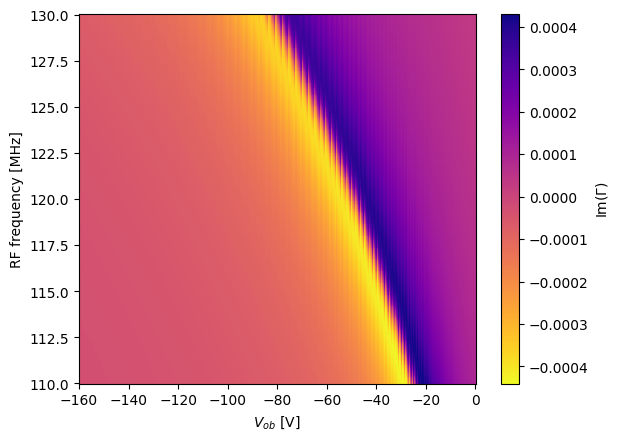

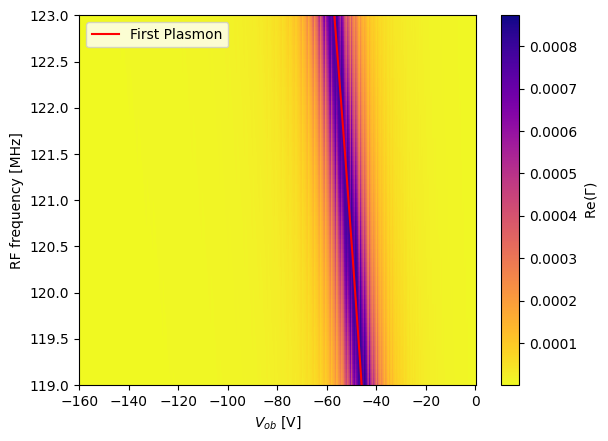

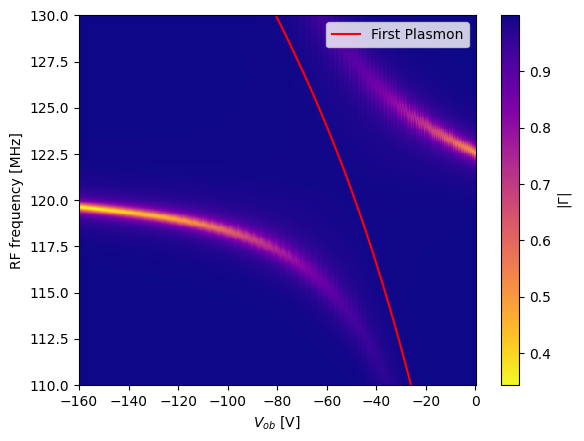

In [97]:

f_LC=cp.asnumpy(omega_vector)/(2*np.pi)

# creates matrices with the real and imaginary parts of the impedance
Matrix_Imag = np.zeros((len(DataStruct), len(cp.asnumpy(DataStruct[0]['Impedance']))))

for i in range(0, len(DataStruct)):
    Matrix_Imag[i] = (np.imag(cp.asnumpy(DataStruct[i]['Impedance'])))

Matrix_Real = np.zeros((len(DataStruct), len(cp.asnumpy(DataStruct[0]['Impedance']))))

for i in range(0, len(DataStruct)):
    Matrix_Real[i] = (np.real(cp.asnumpy(DataStruct[i]['Impedance'])))

Z0=50 

# values from the paper: https://doi.org/10.48550/arXiv.2504.09890
Cc=0.315083*1e-12
L=708*1e-9
C=2.130737*1e-12
Res=321.98*1e3
omegaLC = 1/np.sqrt(L*C)
omegaR=np.sqrt(C/(C+Cc))*omegaLC
fr=omegaR/(2*np.pi)
angular_kappa=(1/Res + ((omegaR*Cc*Z0)**2)/Z0 )/(C+Cc)
print('kappa='+str((angular_kappa/(2*np.pi))*1e-6))





print('f_{LC}='+str(1e-6*omegaLC/(2*cp.pi))+'MHz') 
print('f_{R}='+str(1e-6*fr)+'MHz') 


# see Sec V of the calculations for the derivations of the formulas
Q0=omegaLC*C*Res

OneOverZp=1j * np.matrix(Matrix_Imag).T/Vit_AC/9e11 + np.matrix(Matrix_Real).T/Vit_AC/9e11

phase=-1
ZL=Res/(1+phase*1j*Q0*(cp.asnumpy(omega_vector)/omegaLC-omegaLC/cp.asnumpy(omega_vector)))


OneOverZL = np.zeros((len(DataStruct), len(ZL)), dtype = "complex")
for i in range(0, len(DataStruct)):
    OneOverZL[i] = 1/ZL


Z_L_new = 1/(np.matrix(OneOverZL).transpose() + np.matrix(OneOverZp))
# if you want to check the plot without the plasmon
# Z_L_new = 1/(np.matrix(OneOverZL).transpose() )

CouplingMatrix = np.zeros((len(DataStruct), len(omega_vector)), dtype = "complex")
for i in range(0, len(DataStruct)):
    CouplingMatrix[i] = 1/(phase*1j*cp.asnumpy(omega_vector)*Cc)

Z_l = np.matrix(CouplingMatrix).transpose()+ np.matrix(Z_L_new)


Gamma = (Z_l - Z0)/(Z_l + Z0)


#---------------- plot ------------------#
plasmon_labels = ["First"]
colors = ['r']

plt.pcolormesh(np.array(VobVector), cp.asnumpy(omega_vector)/(2*np.pi*1e6), (np.imag(OneOverZp)), shading="auto", cmap = 'plasma_r')
plt.colorbar(label='Im($\Gamma$)')
plt.xlabel('$V_{ob}$ [V]')
plt.ylabel('RF frequency [MHz]')
plt.show()


plt.pcolormesh(np.array(VobVector), cp.asnumpy(omega_vector)/(2*np.pi*1e6), (np.real(OneOverZp)), shading="auto", cmap = 'plasma_r')



for color, name in zip(colors,plasmon_labels):
    plt.plot(np.array(VobVector), spline_plot[name](np.array(VobVector)), color = color, label = name+' Plasmon')

plt.xlabel('$V_{ob}$ [V]')
plt.ylabel('RF frequency [MHz]')
plt.ylim((119, 123))  
plt.colorbar(label='Re($\Gamma$)')
plt.legend()
plt.show()



Gamma=np.asarray(Gamma)
plt.pcolormesh(np.array(VobVector), cp.asnumpy(omega_vector)/(2*np.pi*1e6), np.abs(Gamma), shading="auto", cmap = 'plasma_r')
plt.colorbar(label='$|\Gamma|$')
plt.xlabel('$V_{ob}$ [V]')
plt.ylabel('RF frequency [MHz]')

for color, name in zip(colors,plasmon_labels):
    plt.plot(np.array(VobVector), spline_plot[name](np.array(VobVector)), color = color, label = name+' Plasmon')

plt.ylim((110, 130))  
plt.legend()
plt.show()





## Calculate the modes

-51.3


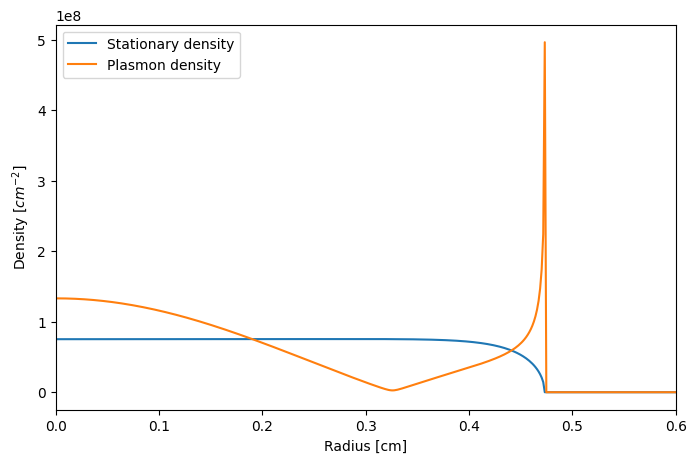

C:\Users\riken\AppData\Local\Temp\ipykernel_59224\2050298814.py:106: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, Z,  shading='nearest', cmap='viridis')


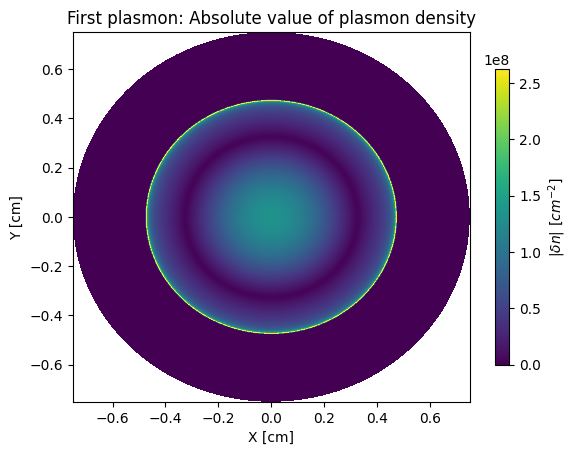

C:\Users\riken\AppData\Local\Temp\ipykernel_59224\2050298814.py:113: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, Z_imag,  shading='nearest', cmap='viridis')


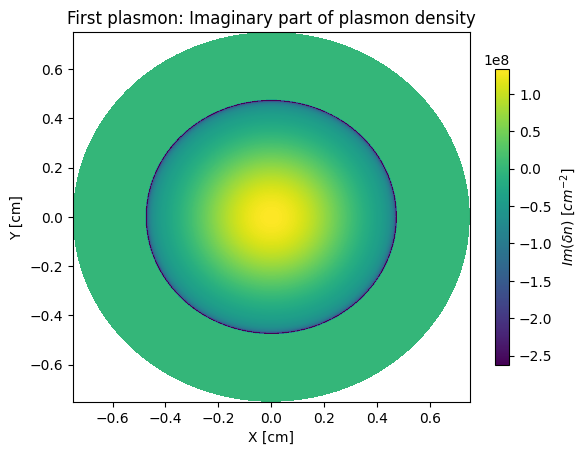

C:\Users\riken\AppData\Local\Temp\ipykernel_59224\2050298814.py:121: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, Z_real,  shading='nearest', cmap='viridis')


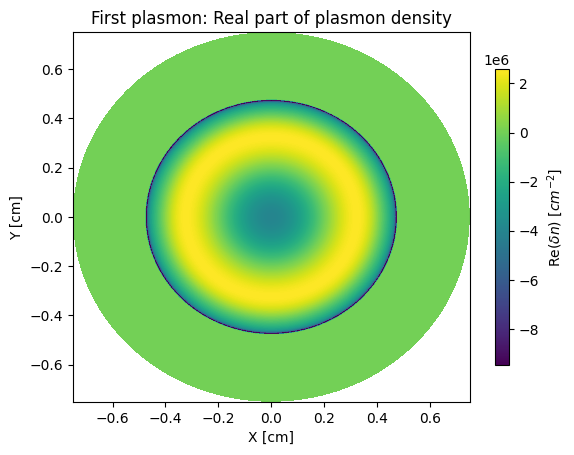

In [98]:
from scipy.ndimage import gaussian_filter
Plasmon_number='First'
plt.figure(figsize=(8, 5))

#choose V_ob at which you want to calculate the moder
voltage=spline_plasmon[Plasmon_number].roots()[0]


fileIndex = np.argmin(np.abs(np.array(VobVector)-voltage))
print(VobVector[fileIndex])
plasmon_frequency=DataStruct[fileIndex][Plasmon_number + 'Plasmon']*2*np.pi*1e6
omega = plasmon_frequency

tau =4.039465e-8

deltafunc = cp.eye(N+1,N+1)
E = cp.zeros((N, N), dtype = "complex")
D = cp.zeros((N, N), dtype = "complex")
F = cp.zeros((N, N), dtype = "complex")
H = cp.zeros((N, N), dtype = "complex")
sigma = cp.zeros(N, dtype = "complex")
b = cp.zeros(N, dtype = "complex")
density_AC = cp.zeros(N, dtype = "complex")



# ------- Find radius_of_electron_pool  -------- #
density=cp.array(DataStruct[fileIndex]["density"])
# hr * K = radius_of_electron_pool
# with the notations of the calculations, K=m+1
K = np.amin((np.nonzero(np.array(cp.asnumpy(density)) == 0))) 

cp.copyto(E[0:K, 0:K], EStart[0:K, 0:K])
cp.copyto(D[0:K, 0:K], DStart[0:K, 0:K])

# -------- Calculate D----------- #
D[0:K,0:K]=deltafunc[0:K,0:K]*A[0:K]
rdash=cp.array(rdash)

# -------- Calculate E----------- #
# Only the coefficients in positions [0:K, 0:K] of the matrices E, D and F are used for the calculations of the modes 
E[0:K, 0] = -1 * rdash[0]*density[0]*(dGr[K,0]*A[0:K]/A[K]-dGr[0:K,0])
for j in range(0, K):
    E[j,1:K] = -1 * rdash[1:K]*density[1:K]*(dGr[K,1:K]*A[j]/A[K]-dGr[j,1:K])+rdash[0:K-1]*density[0:K-1]*(dGr[K,0:K-1]*A[j]/A[K]-dGr[j,0:K-1])






# -------- Calculate sigma, the conductivity----------- #
sigma[0:K] = cp.power(e, 2) * density[0:K] * tau/(mass * (1 - 1j * omega * tau))

# -------- Calculate F----------- #
F=cp.power(e, 2) * E * tau/(mass * (1 - 1j * omega * tau))

# -------- Calculate b----------- #
b[0] = rdash[0] * sigma[0] * Ertil[0]
b[K-1] = -1 * rdash[K-2]*sigma[K-2]*Ertil[K-2]
b[1:K-1] = rdash[1:K-1] * sigma[1:K-1] * Ertil[1:K-1] - rdash[0:K-2] * sigma[0:K-2] * Ertil[0:K-2]
# b[1:K] = rdash[1:K] * sigma[1:K] * Ertil[1:K] - rdash[0:K-1] * sigma[0:K-1] * Ertil[0:K-1]
    
# -------- Calculate H----------- #
H[0:K,0:K] = -1j * (omega * e/(2*cp.pi))*D[0:K,0:K]+F[0:K,0:K]
    
#----------Calculate the densities ie the \delta n (cf calculations) ----------- #
density_AC[0:K] = cp.dot((b[:K]),cp.linalg.inv((H[:K,:K])))
# ------------------ use conservation of charge --------------------- #
density_AC[K] -= cp.sum(A[0:K] * (density_AC[0:K])/A[K])
# ------------------ out of pool --------------------- #
density_AC[K+1:N] = 0


theta = np.linspace(0, 4 * np.pi, 10000)
R, Theta = np.meshgrid(cp.asnumpy(rdash[0:N]), theta)


X = R * np.cos(Theta)
Y = R * np.sin(Theta)




density_AC=cp.asnumpy(density_AC)
density=cp.asnumpy(density)
Z = np.tile(np.abs(density_AC[0:N]), (len(theta), 1))
Z_real= np.tile(np.real(density_AC[0:N]), (len(theta), 1))
Z_imag= np.tile(np.imag(density_AC[0:N]), (len(theta), 1))





Z = gaussian_filter(Z, sigma=1)
Z_real = gaussian_filter(Z_real, sigma=1)
Z_imag = gaussian_filter(Z_imag, sigma=1)   

plt.plot(cp.asnumpy(rdash[0:N]), density[0:N], label='Stationary density')
plt.plot(cp.asnumpy(rdash[0:N]), np.abs(density_AC[0:N]), label='Plasmon density')
plt.xlim([0,0.6])
plt.xlabel('Radius [cm]')
plt.ylabel('Density $[cm^{-2}]$')
plt.legend()
plt.show()

plt.pcolormesh(X, Y, Z,  shading='nearest', cmap='viridis')
plt.title(Plasmon_number+' plasmon: Absolute value of plasmon density')
plt.colorbar(label=r'$|\delta n|\  [cm^{-2}]$', shrink=0.8)
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')    
plt.show()

plt.pcolormesh(X, Y, Z_imag,  shading='nearest', cmap='viridis')
# plt.figure(figsize=(6, 7))
plt.colorbar(label=r'$Im(\delta n) \ [cm^{-2}]$', shrink=0.8)
plt.title(Plasmon_number+' plasmon: Imaginary part of plasmon density')
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')    
plt.show()

plt.pcolormesh(X, Y, Z_real,  shading='nearest', cmap='viridis')
# plt.figure(figsize=(6, 7))
plt.colorbar(label= r'Re($\delta n) \ [cm^{-2}]$', shrink=0.8)
plt.title(Plasmon_number+ ' plasmon: Real part of plasmon density')
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')    
plt.show()